# Описание проекта

Проектная работа связана с анализом продаж игр по всему миру для интернет-магазина.

**Цель работы** состоит в том, чтобы определить для каких игр интернет-магазину будет выгоднее всего спланировать рекламную кампанию и потратить соответствующий бюджет для промотирования.

**Задачи исследования:**
1. Проанализировать игры в контексте продаж в целом и по отдельным регионам
2. Определить критерии и закономерности "успешных" игр
3. Предложить несколько игр, которые на основании полученных данных следует продвигать

**План исследования**:
1. Обзор имеющихся данных
2. Их предобработка
3. Исследование закономерностей
4. Составление портрета потребителей по регионам
5. Проверка гипотез

# Импорт основных модулей и библиотек

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import scipy.stats as st
import datetime as dt
import matplotlib.pyplot as plt
import re

import warnings
warnings.filterwarnings('ignore')

# 1. Обзор данных

In [2]:
df = pd.read_csv('/datasets/games.csv')

In [3]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Наблюдения:
* В данных есть пропуски
* Названия столбцов надо будет стандартизировать: привести к нижнему регистру и по возможности сократить для удобства
* Типы данных для столбцов надо поменять в соответствии с их значениями. Например, нужно будет перевести год релиза в int вместо float

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Пропуски в данных подтверждаются: пропущенные значения есть в столбцах year_of_release, critic_score, user_score, rating

In [5]:
df.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


Этот метод в очередной раз подтверждает, что в данных есть пропуски, а также показывает базовые статистики по каждому из числовых столбцов. Существенных наблюдений по метрикам у меня пока что нет, буду отсматривать графики.

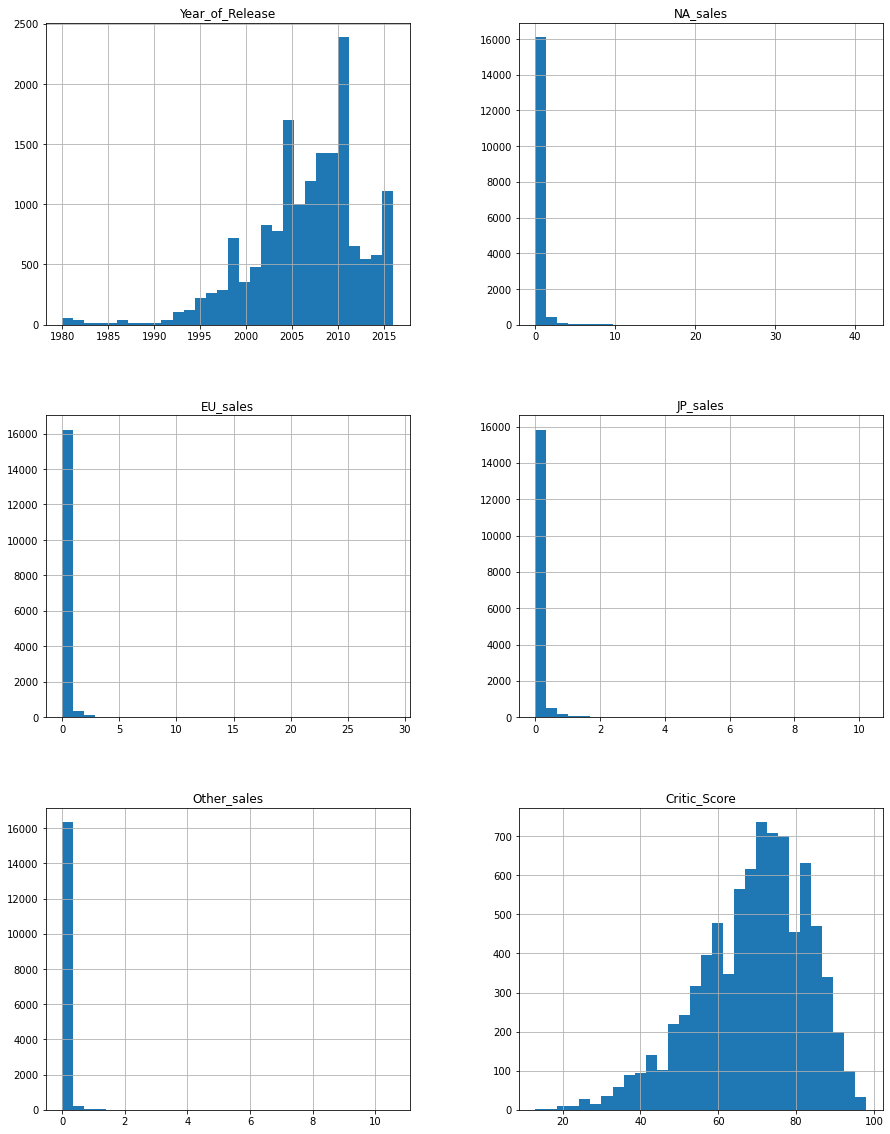

In [6]:
df.hist(figsize=(15, 20), bins=30);

Наблюдения:
* Большинство игр было выпущено с 2005 по 2010 год
* Чаще всего критики оценивают игры в пределах 60-85 условных единиц
* Для иллюстрации значений в столбцах с продажами нужны гистограммы с другими параметрами bins и range

In [7]:
print(f"Количество явных дубликатов в данных = {df.duplicated().sum()}")

Количество явных дубликатов в данных = 0


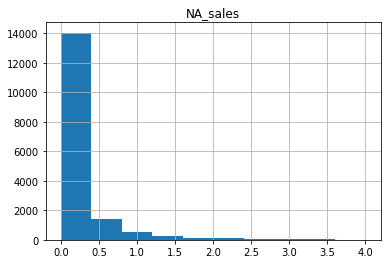

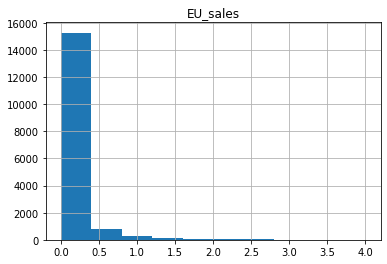

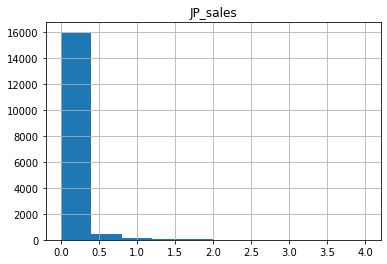

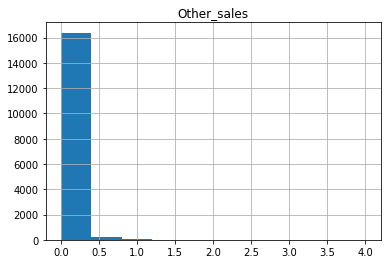

In [8]:
for column in df.columns.tolist():
    if 'sales' in column:
        try:
            df.hist(column, range=(0, 4), bins=10)
            plt.show()
        except KeyError:
            print(f"We cannot draw a histogram for the column '{column}'")
            continue

Такое чувство, что во всех столбцах с продажами есть много нулевых значений. Проверю это предположение детальнее в исследовательском анализе.

# 2. Предобработка данных

**2.1. Переименование столбцов**

In [9]:
df.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')

* Мне будет удобнее, если игры будут не в столбце name (имя), а в более очевидном столбце game (игра)
* Просто для краткости можно перименовать год релиза в два слова: release_year
* Все столбцы нужно привести к нижнему регистру

In [10]:
df.rename(columns={
    'Name': 'game',
    'Year_of_Release': 'release_year'},
          inplace=True)

In [11]:
df.columns = [i.lower() for i in df.columns]

In [12]:
df.columns

Index(['game', 'platform', 'release_year', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

**2.2. Обработка пропусков**

In [13]:
df.isna().sum()

game               2
platform           0
release_year     269
genre              2
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score    8578
user_score      6701
rating          6766
dtype: int64

In [14]:
df.head(20)

,game,platform,release_year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [15]:
# Количество наблюдений в данных, когда отсутствует информация по всем трём типам оценок:
# от юзеров, от экспертов и от организации ESRB
df[(df['critic_score'].isna()) &
  (df['user_score'].isna()) &
  (df['rating'].isna())
  ]['game'].count()

6619

**Почему могли возникнуть эти пропуски:**
* **game (название игры)**: это могли быть случайные два пропуска, когда забыли указать название игры. Такое небольшое количество пропусков можно будет откинуть, и это не повлияет на результат анализа.
* **release_year**: как вариант, игра могла быть ещё не выпущена в общее использование, но на неё уже запустили предпродажу, поэтому данные о её продажах уже есть, но финальный год выпуска ещё не известен. Кроме того, год релиза мог быть не указан ещё и потому, что игра могла быть достаточно старой, и точного года её выпуска пользователь мог не знать / не найти информацию об этом. Это же предположение, в целом, применимо и для современных игр, как мне кажется.
* **critic_score**, **user_score**, **rating**: по данным заметно, что часто пропуски во всех трёх колонках с рейтингами появлялись одновременно (то есть отсутствовали какие-либо оценки для игры в целом), причём такое наблюдается в основном для игр, которые были выпущены раньше 2000-го года. Предположение: до 2000 года оценки пользователей, критиков и ESRB могли редко собираться / не собираться вообще.
* **rating**: отдельно хочется прокомментировать пропуск в этой колонке, поскольку рейтинг ESRB распространяется только на США и Канаду. Таким образом, кажется, что пропуски в этой колонке могут быть обсуловлены сбором данных в датасете по всему миру, а не только по этим двум странам.

In [16]:
269 / df.shape[0]

0.01609332934489979

* В названиях игр и всего два пропуска - смело удаляю эти строки полностью
* Пропуски в годах публикации игр занимают всего 1-2% от всех данных - тоже удаляю
* Пропуски в critic_score, user_score я бы хотел заполнить медианным значением в зависимости от жанра, но мне кажется, что такое заполнение исказит анализ данных. Поэтому пропуски в этих двух столбцах и в rating я заменю на значение 'не указано'

In [17]:
df.dropna(subset=['game', 'release_year'], axis=0, inplace=True)

In [18]:
for column_with_na in ['critic_score', 'user_score', 'rating']:
    df[column_with_na].fillna('не указано', inplace=True)

In [19]:
df.isna().sum()

game            0
platform        0
release_year    0
genre           0
na_sales        0
eu_sales        0
jp_sales        0
other_sales     0
critic_score    0
user_score      0
rating          0
dtype: int64

**2.3. Изменение типов данных**

In [20]:
df.head()

,game,platform,release_year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,не указано,не указано,не указано
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,не указано,не указано,не указано


In [21]:
df.dtypes

game             object
platform         object
release_year    float64
genre            object
na_sales        float64
eu_sales        float64
jp_sales        float64
other_sales     float64
critic_score     object
user_score       object
rating           object
dtype: object

In [22]:
df['critic_score'].unique()

array([76.0, 'не указано', 82.0, 80.0, 89.0, 58.0, 87.0, 91.0, 61.0, 97.0,
       95.0, 77.0, 88.0, 83.0, 94.0, 93.0, 85.0, 86.0, 98.0, 96.0, 90.0,
       84.0, 73.0, 74.0, 78.0, 92.0, 71.0, 72.0, 68.0, 62.0, 49.0, 67.0,
       81.0, 66.0, 56.0, 79.0, 70.0, 59.0, 64.0, 75.0, 60.0, 63.0, 69.0,
       50.0, 25.0, 42.0, 44.0, 55.0, 48.0, 57.0, 29.0, 47.0, 65.0, 54.0,
       20.0, 53.0, 37.0, 38.0, 33.0, 52.0, 30.0, 32.0, 43.0, 45.0, 51.0,
       40.0, 46.0, 39.0, 34.0, 41.0, 36.0, 31.0, 27.0, 35.0, 26.0, 19.0,
       28.0, 23.0, 24.0, 21.0, 17.0, 13.0], dtype=object)

In [23]:
df['user_score'].unique()

array(['8', 'не указано', '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3',
       '7.4', '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8',
       '3.2', '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3',
       '4.3', '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4',
       '6.8', '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2',
       '6', '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

* Заменяю release_year на тип int, т.к. год - это целочисленное значение
* critic_score привожу к тому же виду, т.к. в этом столбце находятся только целочисленные значения
* user_score, напротив, меняю на float, т.к. там есть числовые нецелочисленные значения
* в user_score есть отдельная строка 'tbd' - поменяю такие значения на 'не указано', т.к. 'to be determined' схоже с этим значением по смыслу в данном случае

In [24]:
df['release_year'] = df['release_year'].astype(int)

In [25]:
df.loc[df['critic_score'] != 'не указано', 'critic_score'] = df.loc[
    df['critic_score'] != 'не указано', 'critic_score'].astype(int)

In [26]:
df.loc[df['user_score'] == 'tbd', 'user_score'] = 'не указано'

In [27]:
df.loc[df['user_score'] != 'не указано', 'user_score'] = df.loc[
    df['user_score'] != 'не указано', 'user_score'].astype(float)

In [28]:
df.dtypes

game             object
platform         object
release_year      int64
genre            object
na_sales        float64
eu_sales        float64
jp_sales        float64
other_sales     float64
critic_score     object
user_score       object
rating           object
dtype: object

**2.4. Суммарные продажи по регионам**

In [29]:
df.head()

,game,platform,release_year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,не указано,не указано,не указано
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,не указано,не указано,не указано


In [30]:
for column in df.columns.tolist():
    if 'sale' in column:
        print(f"Суммарные продажи для {column} составили {round(df[column].sum())} миллионов.")

Суммарные продажи для na_sales составили 4341 миллионов.
Суммарные продажи для eu_sales составили 2400 миллионов.
Суммарные продажи для jp_sales составили 1291 миллионов.
Суммарные продажи для other_sales составили 783 миллионов.


In [31]:
df['total_sales'] = df['na_sales']\
    + df['eu_sales']\
    + df['jp_sales']\
    + df['other_sales']

# альтернативный метод: = data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

In [32]:
df[['game', 'total_sales']].head()

,game,total_sales
0,Wii Sports,82.54
1,Super Mario Bros.,40.24
2,Mario Kart Wii,35.52
3,Wii Sports Resort,32.77
4,Pokemon Red/Pokemon Blue,31.38


In [33]:
# Посмотрим, что у нас осталось
temp = df.copy() 
list_c = ['game', 'platform', 'release_year', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].unique())
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   game          16444 non-null  object 
 1   platform      16444 non-null  object 
 2   release_year  16444 non-null  int64  
 3   genre         16444 non-null  object 
 4   na_sales      16444 non-null  float64
 5   eu_sales      16444 non-null  float64
 6   jp_sales      16444 non-null  float64
 7   other_sales   16444 non-null  float64
 8   critic_score  16444 non-null  object 
 9   user_score    16444 non-null  object 
 10  rating        16444 non-null  object 
 11  total_sales   16444 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 1.6+ MB
None
-------------------------
game ['Wii Sports' 'Super Mario Bros.' 'Mario Kart Wii' ...
 'Woody Woodpecker in Crazy Castle 5' 'LMA Manager 2007'
 'Haitaka no Psychedelica']
game : кол-во NaN 0 , процент NaN 0.0 %
-----------

# 3. Исследовательский анализ

**3.1. Релиз игр в разные годы**

In [34]:
releases_by_year = df.pivot_table(index='release_year', values='game', aggfunc='count')
releases_by_year

,game
release_year,
1980,9
1981,46
1982,36
1983,17
1984,14
1985,14
1986,21
1987,16
1988,15


С 1980 по 1994 стабильно выпускалось меньше 100 игр. Посчитаем общее количество игр, выпущенное за этот период.

In [35]:
releases_by_year[releases_by_year['game'] < 100].sum() / releases_by_year['game'].sum() * 100

game    2.219655
dtype: float64

Игры, выпущенные с 1980 по 1993 год включительно, занимают в датасете всего 2.2% - данные  релизов в эти годы можно удалить без вреда анализу.

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   game          16444 non-null  object 
 1   platform      16444 non-null  object 
 2   release_year  16444 non-null  int64  
 3   genre         16444 non-null  object 
 4   na_sales      16444 non-null  float64
 5   eu_sales      16444 non-null  float64
 6   jp_sales      16444 non-null  float64
 7   other_sales   16444 non-null  float64
 8   critic_score  16444 non-null  object 
 9   user_score    16444 non-null  object 
 10  rating        16444 non-null  object 
 11  total_sales   16444 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 1.6+ MB


In [37]:
df = df[df['release_year'] >= 1994]

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16079 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   game          16079 non-null  object 
 1   platform      16079 non-null  object 
 2   release_year  16079 non-null  int64  
 3   genre         16079 non-null  object 
 4   na_sales      16079 non-null  float64
 5   eu_sales      16079 non-null  float64
 6   jp_sales      16079 non-null  float64
 7   other_sales   16079 non-null  float64
 8   critic_score  16079 non-null  object 
 9   user_score    16079 non-null  object 
 10  rating        16079 non-null  object 
 11  total_sales   16079 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 1.6+ MB


**3.2. Продажи по платформам**

Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

In [39]:
df.head()

,game,platform,release_year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,не указано,не указано,не указано,31.38
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89,8.5,E,29.80


In [40]:
top10_platforms_by_sales = df.groupby('platform')['total_sales'].sum()\
    .sort_values(ascending=False)[:10].index.tolist()
print(*top10_platforms_by_sales)

PS2 X360 PS3 Wii DS PS PS4 GBA PSP 3DS


In [41]:
top10_platforms_over_years = df[df['platform'].isin(top10_platforms_by_sales)]\
    .pivot_table(index='release_year',
                 columns='platform',
                 values='total_sales',
                 aggfunc='sum')
top10_platforms_over_years

platform,3DS,DS,GBA,PS,PS2,PS3,PS4,PSP,Wii,X360
release_year,,,,,,,,,,
1994,NaN,NaN,NaN,6.03,NaN,NaN,NaN,NaN,NaN,NaN
1995,NaN,NaN,NaN,35.96,NaN,NaN,NaN,NaN,NaN,NaN
1996,NaN,NaN,NaN,94.70,NaN,NaN,NaN,NaN,NaN,NaN
1997,NaN,NaN,NaN,136.17,NaN,NaN,NaN,NaN,NaN,NaN
1998,NaN,NaN,NaN,169.49,NaN,NaN,NaN,NaN,NaN,NaN
1999,NaN,NaN,NaN,144.53,NaN,NaN,NaN,NaN,NaN,NaN
2000,NaN,NaN,0.07,96.37,39.17,NaN,NaN,NaN,NaN,NaN
2001,NaN,NaN,61.53,35.59,166.43,NaN,NaN,NaN,NaN,NaN
2002,NaN,NaN,74.16,6.67,205.38,NaN,NaN,NaN,NaN,NaN


По сводной таблице заметно, что игры для  конкретных платформ продавались лишь в течение определённого количества лет. Посчитаю, сколько в среднем лет игры для каждой платформы продаются.

In [42]:
platforms_by_years_when_sold = {}

for platform in top10_platforms_over_years:
    platforms_by_years_when_sold[platform] = \
        top10_platforms_over_years[platform].notna().sum()
    
for platform, years_when_sold in platforms_by_years_when_sold.items():
    print(f"For the platform {platform}, games had been sold over {years_when_sold} years.")

print()
    
print(f"On average, games are sold for \
{sum(platforms_by_years_when_sold.values()) / len(platforms_by_years_when_sold.values())} years per platform.")

For the platform 3DS, games had been sold over 6 years.
For the platform DS, games had been sold over 10 years.
For the platform GBA, games had been sold over 8 years.
For the platform PS, games had been sold over 10 years.
For the platform PS2, games had been sold over 12 years.
For the platform PS3, games had been sold over 11 years.
For the platform PS4, games had been sold over 4 years.
For the platform PSP, games had been sold over 12 years.
For the platform Wii, games had been sold over 11 years.
For the platform X360, games had been sold over 12 years.

On average, games are sold for 9.6 years per platform.


В среднем, игры для конкретной платформы продавались в течение 9.6 лет. Это наблюдение применимо именно к топ-10 платформам по суммарному количеству проданных игр в нашем датасете.

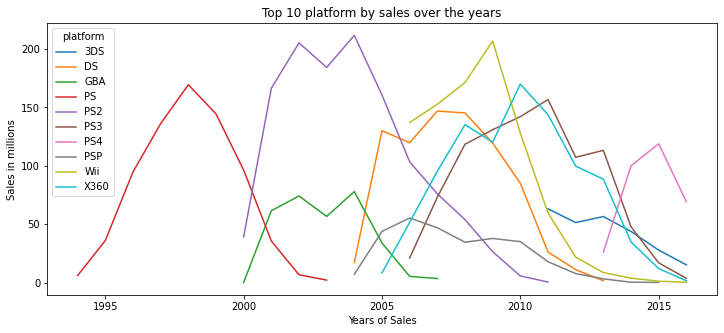

In [43]:
df[df['platform'].isin(top10_platforms_by_sales)]\
    .pivot_table(index='release_year',
                 columns='platform',
                 values='total_sales',
                 aggfunc='sum')\
    .plot(figsize=(12, 5), title='Top 10 platform by sales over the years',
          xlabel='Years of Sales',
          ylabel='Sales in millions');

По общему графику видно, что на смену одним платформам приходят другие. Посмотрим на продажи для каждой отдельной платформы в разрезе лет.

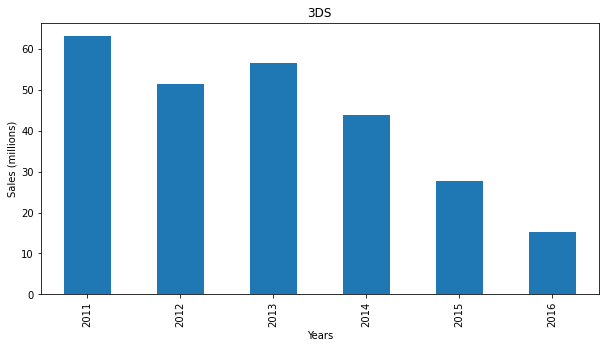

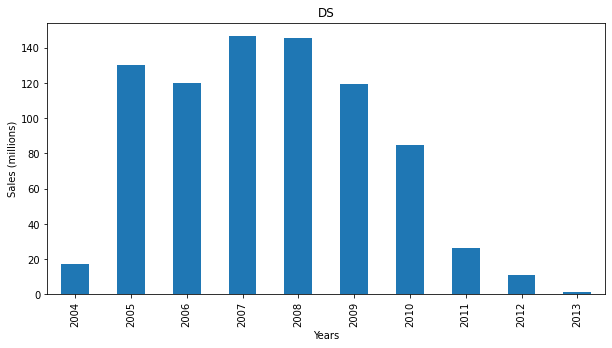

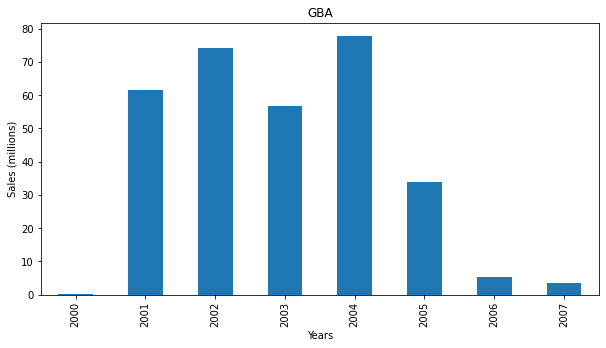

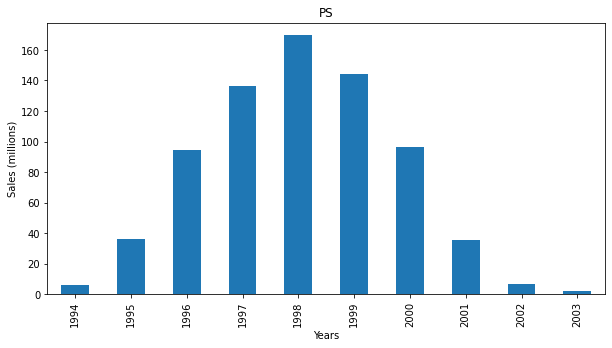

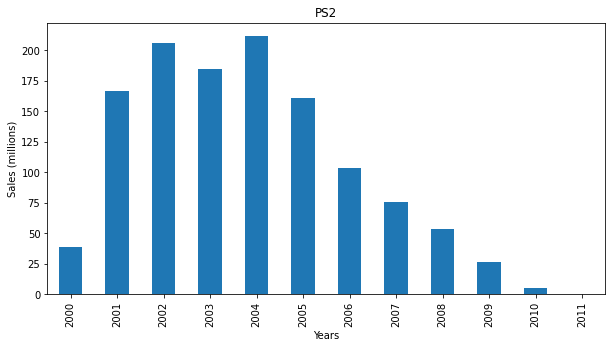

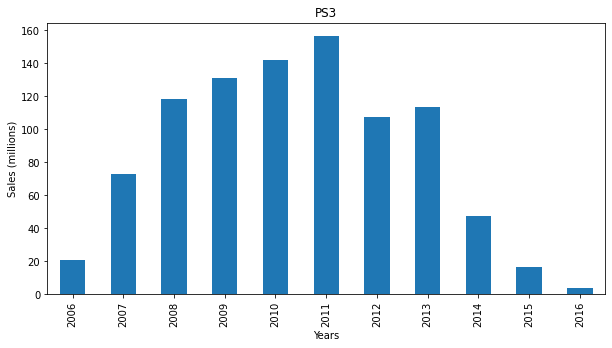

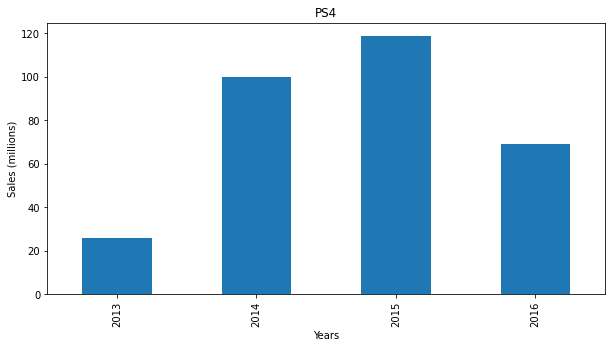

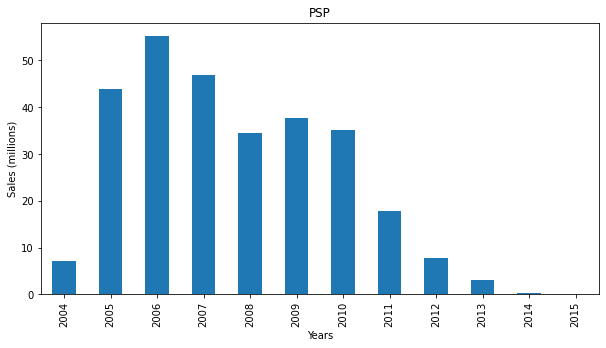

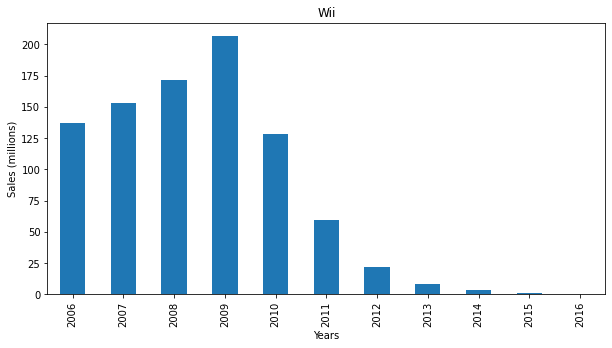

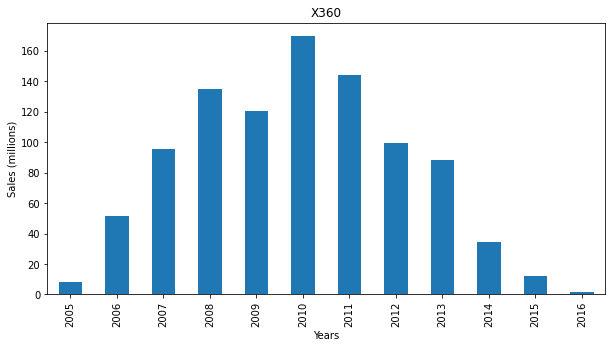

In [44]:
for platform in top10_platforms_over_years:
    plt.subplots(figsize=(10, 5))
    top10_platforms_over_years[top10_platforms_over_years[platform].notna()==True][platform].plot(
        kind='bar',
        title=platform,
        xlabel='Years',
        ylabel='Sales (millions)')
    print()
    plt.show()

Несмотря на то, что продажи игр для топ-10 платформ осуществлялись в среднем  в течение 9.6 лет, практически для всех платформ из этого списка **большинство** продаж осуществлялось лишь в течение 5-6 лет. 

Новые платформы возникали в течение чуть ли не каждого года, в то время как старые платформы исчезали в течение ~3 лет.

**3.3. Определение актуального периода, который поможет построить прогноз на 2017 год**

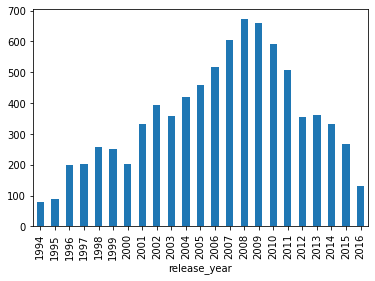

In [45]:
df.groupby('release_year')['total_sales'].sum().plot(kind='bar');

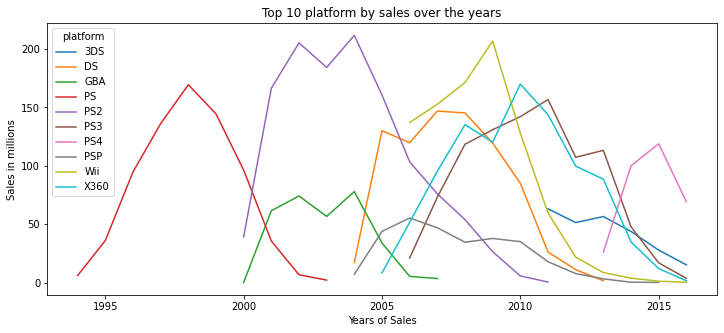

In [46]:
df[df['platform'].isin(top10_platforms_by_sales)]\
    .pivot_table(index='release_year',
                 columns='platform',
                 values='total_sales',
                 aggfunc='sum')\
    .plot(figsize=(12, 5), title='Top 10 platform by sales over the years',
          xlabel='Years of Sales',
          ylabel='Sales in millions');

Судя по этим двум графикам, предполагаю, что за актуальный период для дальнейшего исследования нужно взять интервал с 2005 по 2015 год. В этом промежутке лежит основная часть топ-10 платформ по суммарным продажам игр. Правую границу 2016 год не рассматриваем, поскольку в самой задаче указано, что за 2016 могут быть неполные данные. Это может объяснять то, что большинство платформ на графике сильно проседает по продажам именно в последний год.

**3.4. Не учитывайтем в работе данные за предыдущие годы**

In [47]:
df_actual = df[df['release_year'] >= 2014]

In [48]:
df_actual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689 entries, 31 to 16714
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   game          1689 non-null   object 
 1   platform      1689 non-null   object 
 2   release_year  1689 non-null   int64  
 3   genre         1689 non-null   object 
 4   na_sales      1689 non-null   float64
 5   eu_sales      1689 non-null   float64
 6   jp_sales      1689 non-null   float64
 7   other_sales   1689 non-null   float64
 8   critic_score  1689 non-null   object 
 9   user_score    1689 non-null   object 
 10  rating        1689 non-null   object 
 11  total_sales   1689 non-null   float64
dtypes: float64(5), int64(1), object(6)
memory usage: 171.5+ KB


**3.5. Выбираем несколько потенциально прибыльных платформ**

In [49]:
actual_platforms = df_actual.groupby('platform')['total_sales'].sum().\
    sort_values(ascending=False)[:10]
actual_platforms

platform
PS4     288.15
XOne    140.36
3DS      86.68
PS3      68.18
X360     48.22
WiiU     42.98
PC       27.05
PSV      22.40
Wii       5.07
PSP       0.36
Name: total_sales, dtype: float64

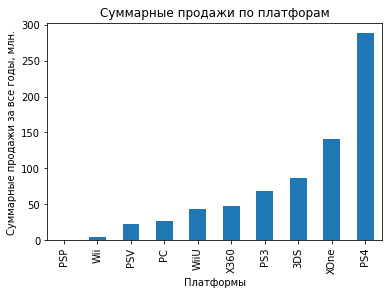

In [50]:
ax = df_actual[df_actual['platform'].isin(actual_platforms.index)].groupby('platform')['total_sales'].sum()\
    .sort_values(ascending=True).plot(
    kind='bar', xlabel='Платформы', ylabel='Суммарные продажи за все годы, млн.',
    title='Суммарные продажи по платфорам')

По группировке и её визуализации заметно, что по суммарным продажам лидирует платформа PS4, причём её продажи превышают второе место - XOne - практически в два раза. Остальными наиболее продаваемыми платформами можно назвать (в порядке убывания продаж) 3DS, PS3 и X360.

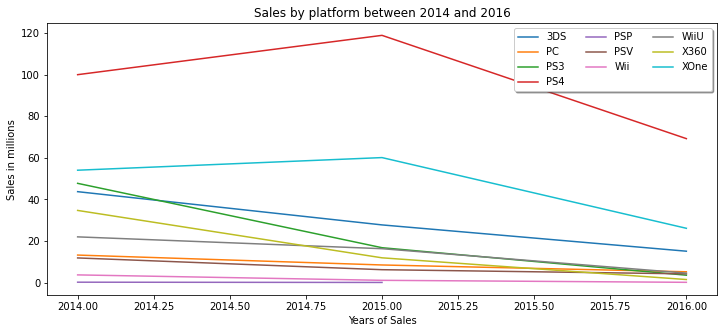

In [51]:
ax = df_actual[df_actual['platform'].isin(actual_platforms.index)]\
    .pivot_table(index='release_year',
                 columns='platform',
                 values='total_sales',
                 aggfunc='sum')\
    .plot(figsize=(12, 5), title='Sales by platform between 2014 and 2016',
          xlabel='Years of Sales',
          ylabel='Sales in millions', 
         );
ax.legend(loc='upper right',
          ncol=3, fancybox=True, shadow=True);

Судя по графику, ни одна из четырех выделенных ранее платформ (DS, Wii, PS3 и X360) не является прибыльной в последние годы. Напротив, продажи игр для этих платформ стабильно снижаются с каждым годом, хотя они ещё есть. Наиболее заметно снижаются продажи для PS3, X360 и 3DS, хотя они ещё есть и выше остальных платформ.

С другой стороны, мы видим, что с 2013 по 2015 достаточно существенно увеличились продажи игр для PS4 (25 млн -> 125 млн) и XOne (25 млн -> 60 млн). Кажется, именно эти две платформы можно считать наиболее прибыльными за последние годы.

Чтобы не рассматривать в своём анализе только две платформы (PS4 и XOne), добавим к выборке более старые платформы, продажи по которым снижаются, но которые по-прежнему привлекают десятки миллионов проданных игр, а именно: 3DS, PS3, X360.

In [52]:
prosperous_platforms = ['PS4', 'XOne', '3DS', 'PS3', 'X360']

In [53]:
top5_platforms_df = df_actual[df_actual['platform'].isin(prosperous_platforms)]

In [54]:
top5_platforms_df['platform'].unique()

array(['PS4', '3DS', 'XOne', 'PS3', 'X360'], dtype=object)

**3.6. График «ящик с усами» по глобальным продажам игр в разбивке по платформам**

Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.

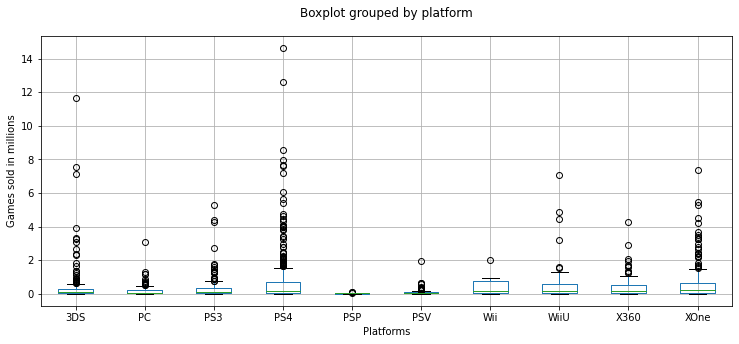

In [55]:
ax = df_actual.boxplot(by='platform', column='total_sales',
                               figsize=(12, 5), grid=True)
ax.set_xlabel('Platforms')
ax.set_ylabel('Games sold in millions')
ax.set_title('');

В целом, без выставленной границы по оси Y график является плохочитаемым: у большинства платформ продажи свыше ~2-3 млн. - это выбросы. Установим границу на 3 млн проданных игр.

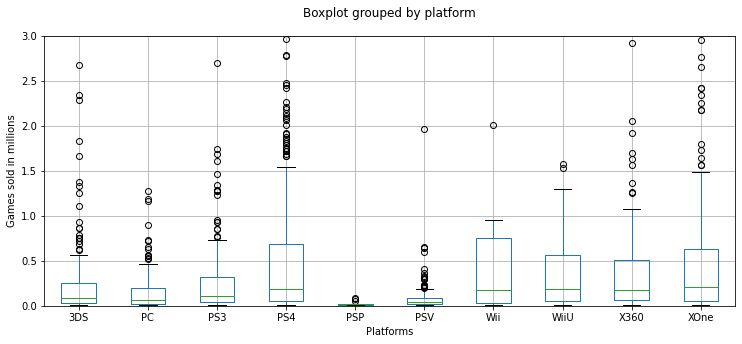

In [56]:
ax = df_actual.boxplot(by='platform', column='total_sales',
                               figsize=(12, 5), grid=True)
ax.set_xlabel('Platforms')
ax.set_ylabel('Games sold in millions')
ax.set_title('')
ax.set_ylim(0, 3);

Наблюдения:
* Продажи для платформы PSP являются самыми менее варьируемыми. Другими словами, их количество меньше поддаётся разнообразию в большую или меньшую стороны, и большая часть продаж зиждится вокруг медианного значения. Кроме того, по наименьшей ширине ящика (расстояние между Q1 и Q3), можно предположить, что продажи для PSP являются наименьшиими. Похожие наблюдения релевантны и для платформы PSV, однако у неё прослеживается гораздо более высокие выбросы по объёму продаж - у этой платформы выше потенциал высоких продаж по отношению к PSP.
* Остальные платформы можно разделить на две группы по схожести распределения продаж: 1) 3DS, PC и PS3, а также 2) PS4, Wii, WiiU, X360 и XOne.
* Для первой группы характерны меньшие объёмы продаж по отношению ко второй части платформ. Помимо этого, по меньшему размеру ящиков можно предположить, что их количество продаж, в целом, не так сильно поддаётся отклонению, как игры для второй группы. При этом, как можно заметить, у 3DS и PS3 есть обильные выбросы в большую сторону. Кажется, для таких платформ **временами** были характерны чрезвычайно высокие продажи, которые в своё время по объёмам превышали текущие показатели.
* Вторая группа платформ является более прибыльными в общем смысле. Хотя их медианное значение лишь слегка больше первой группы, мы видим, что распределение количества продаж (размер ящика) и сам размах в бОльшую сторону заметно шире, чем для первой группы.
* Разброс или распределение продаж для PS4 похоже на XOne. Их наибольший межквартильных размах может говорить нам о том, что показатели продаж по этим платформам могут сильно отклоняться в бОльшую сторону. Кроме того, мы можем наблюдать большое количество выбросов в большую сторону. **Эти две платформы можно считать наиболее привлекательными.**

**3.7. Как влияют отзывы пользователей и критиков на продажи внутри одной популярной платформы**

Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

In [57]:
top5_platforms_df[top5_platforms_df['release_year'].isin([2014, 2015, 2016])].\
    groupby('platform')['total_sales'].sum().sort_values(ascending=False)

platform
PS4     288.15
XOne    140.36
3DS      86.68
PS3      68.18
X360     48.22
Name: total_sales, dtype: float64

В качестве "популярной платформы" выберем PS4, поскольку именно её продажи являются самыми высокими за последние 3 года: 2014, 2015 и 2016.

In [58]:
ps4_sales_df = top5_platforms_df[top5_platforms_df['platform'] == 'PS4']
ps4_sales_df.head(3)

,game,platform,release_year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,не указано,не указано,не указано,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8.3,M,12.62
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82,4.3,E,8.58


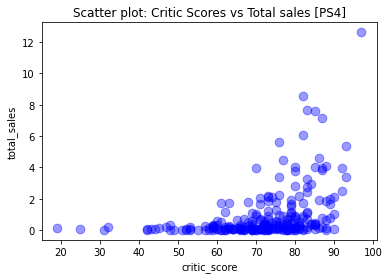

In [61]:
ps4_sales_vs_critics = ps4_sales_df[
    ps4_sales_df['critic_score'] != 'не указано'
        ]

ps4_sales_vs_critics.plot(x='critic_score', y='total_sales', kind='scatter',
          title='Scatter plot: Critic Scores vs Total sales [PS4]',
                  color='blue', s = 75, alpha=0.4);

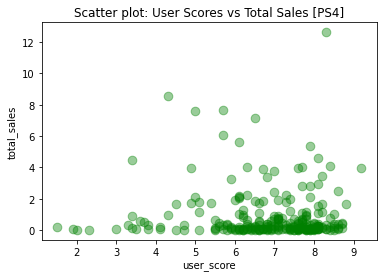

In [62]:
ps4_sales_vs_users = ps4_sales_df[
    ps4_sales_df['user_score'] != 'не указано'
        ]

ps4_sales_vs_users.plot(x='user_score', y='total_sales', kind='scatter',
          title='Scatter plot: User Scores vs Total Sales [PS4]',
                  color='green', s = 75, alpha=0.4);

По графикам рассеивания видно, что заметная корреляция между отзывами и объёмом продаваемых игр для PS4 наблюдается лишь для тех рейтинговых значений, которые оставляют критики, а не обычные пользователи. График рассеивания для значений критиков стремится вправо вверх (прямая корреляция), пусть и с незначительной плотностью пересекаемых значений. График рассеивания для оценок пользователей, напротив, является более пологим и не стремящимся в конкретную сторону.

In [63]:
pearson_critics_vs_sales = round(ps4_sales_vs_critics['total_sales'].corr(
    ps4_sales_vs_critics['critic_score'].astype(int)), 2)

pearson_users_vs_sales = round(ps4_sales_vs_users['total_sales'].corr(
    ps4_sales_vs_users['user_score'].astype(float)), 2)

print(f"Корреляция: отзывы критиков и объём продаж игр для PS4\n:{pearson_critics_vs_sales}")

print(f"Корреляция: отзывы от пользователей и объём продаж игр для PS4\n:{pearson_users_vs_sales}")

Корреляция: отзывы критиков и объём продаж игр для PS4
:0.4
Корреляция: отзывы от пользователей и объём продаж игр для PS4
:-0.04


Значения коэффициентов Пирсона для двух групп показателей - 1) общими продажами и оценками критиков, а также 2) общими продажами и оценками пользователей - подтверждают наблюдения, полученные в ходе анализа графиков рассеивания. Между рейтингами пользователей и объёмами продаж игр для PS4 зависимость не наблюдается, в то время как корреляция между комментариями критиков и объёмом продаваемых игр является заметной и положительной (чем выше рейтинг экспертов, тем выше продажи). Таким образом, объём продаваемых игр для PS4 зависит от оценок критиков, а не пользователей.

**3.8. Соотнесение выводов с продажами игр на других платформах**

In [64]:
def get_pearson_for_platform(platform_name):
    
    platform_df = top5_platforms_df[top5_platforms_df['platform'] == platform_name]
    
    platform_df_critics = platform_df[
        platform_df['critic_score'] != 'не указано'
            ]
    
    pearson_critics_vs_sales = round(platform_df_critics['total_sales'].corr(
    platform_df_critics['critic_score'].astype(int)), 2)
    
    platform_df_users = platform_df[
        platform_df['user_score'] != 'не указано'
            ]

    pearson_users_vs_sales = round(platform_df_users['total_sales'].corr(
    platform_df_users['user_score'].astype(float)), 2)
    
    return pearson_critics_vs_sales, pearson_users_vs_sales

In [65]:
corr_reviews_vs_sales = {}

for platform in top5_platforms_df['platform'].unique():
    corr_reviews_vs_sales[platform] = get_pearson_for_platform(platform)

print('{:^20}|{:^30}|{:^30}'.format('Платформа',
                                  'Продажи vs отзывы критиков',
                                 'Продажи vs отзывы юзеров'))
print('-'*80)
for k, v in corr_reviews_vs_sales.items():
    print('{:^20}|{:^30}|{:^30}'.format(k, v[0], v[1]))

     Платформа      |  Продажи vs отзывы критиков  |   Продажи vs отзывы юзеров   
--------------------------------------------------------------------------------
        PS4         |             0.4              |            -0.04             
        3DS         |             0.28             |             0.28             
        XOne        |             0.42             |            -0.09             
        PS3         |             0.45             |             0.16             
        X360        |             0.53             |             0.34             


In [66]:
def scatter_sales_vs_rating(platform_name, score_type, col_pattern):
    
    platform_sales_vs_critics = ps4_sales_df[
    ps4_sales_df[score_type] != 'не указано'
        ]
    
    platform_sales_vs_critics.plot(x=score_type, y='total_sales', kind='scatter',
          title=f'Scatter plot: {score_type} vs Total sales for {platform_name}',
                  color=col_pattern, s = 75, alpha=0.4);
    
    plt.show()
    
    return None

Диаграммы рассеивания для отображения зависимости продаж от **оценок критиков**.

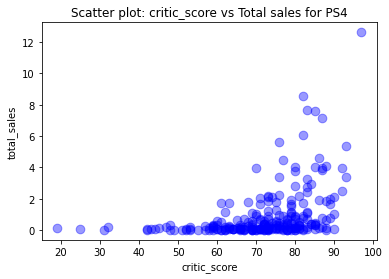

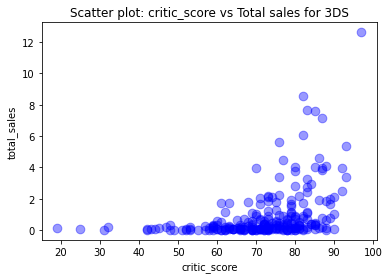

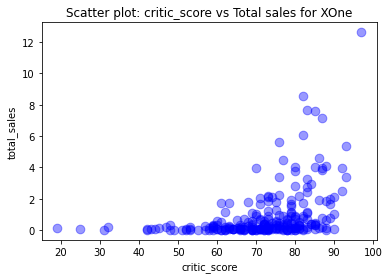

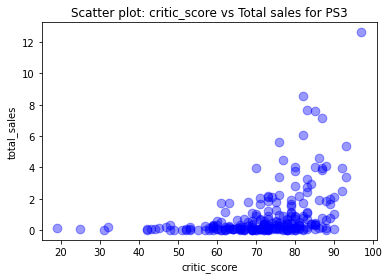

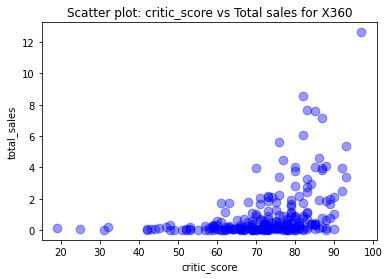

In [67]:
for platform in top5_platforms_df['platform'].unique():
    scatter_sales_vs_rating(platform, 'critic_score', 'blue')

Диаграммы рассеивания для отображения зависимости продаж от **оценок пользователей**.

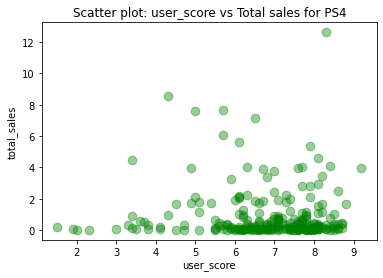

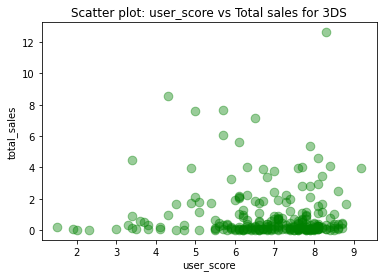

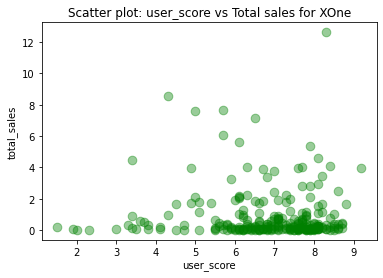

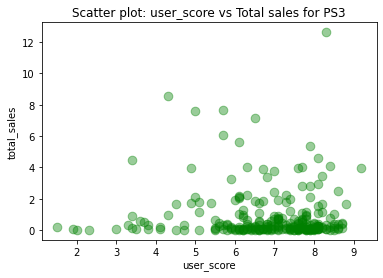

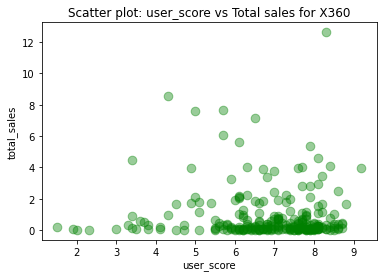

In [68]:
for platform in top5_platforms_df['platform'].unique():
    scatter_sales_vs_rating(platform, 'user_score', 'green')

Вывод о том, что продажи напрямую зависят от отзывов критиков (что наблюдалось в случае PS4), справедлив и для остальных 4 наиболее продаваемых платформ: X360, PS3, 3DS, XOne. Интенсивность корреляции (или значения коэффициента Пирсона) для всех пяти платформ примерно одинаковые, а диаграммы рассеивания стремятся вправо вверх.

С другой стороны, в то время как продажи игр для PS4 не зависят от оценок пользователей вообще, этот вывод полностью неприменим для таких платформ, как X360, PS3 и 3DS. Для каждой из этих трёх платформ наблюдается небольшая положительная зависимость между объёмом продаж и комментариями, которые оставили пользователи: чем выше оценка юзера, тем выше количество продаж. Важно заметить, что такая зависимость не является существенной, но она есть.

**3.9. Общее распределение игр по жанрам**

Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

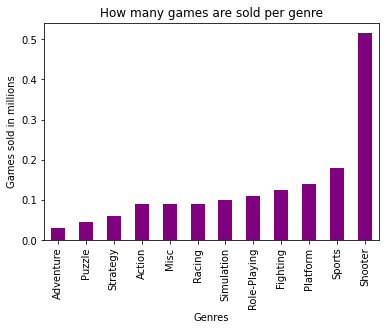

In [69]:
df_actual.groupby('genre')['total_sales'].median()\
    .sort_values(ascending=True).plot(
    kind='bar', xlabel='Genres', ylabel='Games sold in millions',
    title='How many games are sold per genre', color='purple');

По этой столбчатой диаграмме заметно, что бесспорным лидером продаж среди игровых жанров являются шутеры или "стрелялки". Их объём продаж превосходит второе место по продажам - спортивные игры - больше чем в ~2.5 раза. Остальные жанры продаются примерно в одном и том же диапазоне: от ~0.3 млн до ~1.8 млн копий. Наименее популярными жанрами можно считать (в порядке убывания): Стратегии, Пазлы и Приключения.

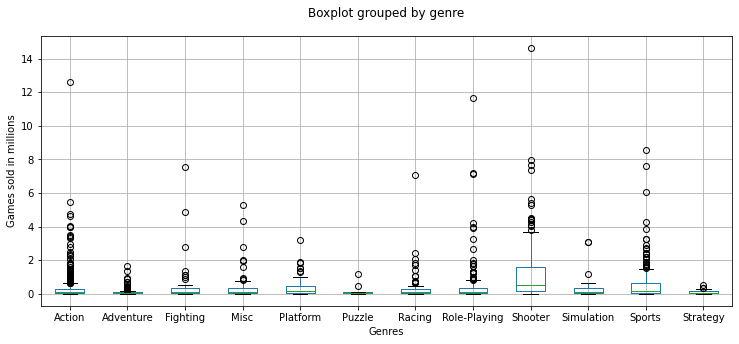

In [70]:
ax = df_actual.boxplot(by='genre', column='total_sales',
                               figsize=(12, 5), grid=True)
ax.set_xlabel('Genres')
ax.set_ylabel('Games sold in millions')
ax.set_title('');

Заметно, что продажи выше 4 млн - это выбросы. Добавим ограничение по оси Y.

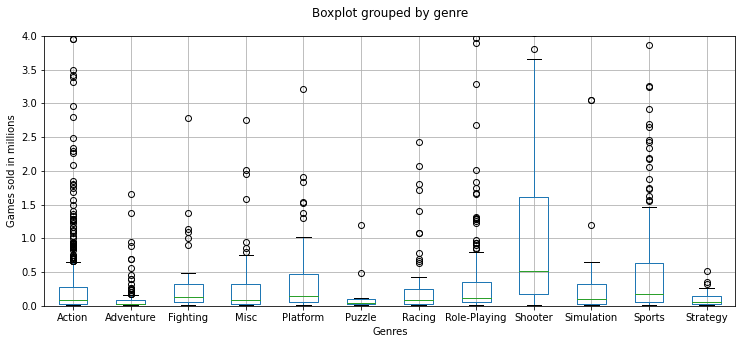

In [71]:
ax = df_actual.boxplot(by='genre', column='total_sales',
                               figsize=(12, 5), grid=True)
ax.set_xlabel('Genres')
ax.set_ylabel('Games sold in millions')
ax.set_title('');
ax.set_ylim(0, 4);

Диаграммы рассеивания в очередной раз подтверждают выводы выше:
* Игры-шутеры представляют собой самый продаваемый жанр. Объёмы продаж игр в этом жанре сильно варьируются в большую от медианы сторону и имеют широкий размах значений, отличных от медианы в целом.
* За несравнимым лидером по продажам - шутерам - идут такие жанры, как (по убыванию): Спортивные игры и Игры-платформеры.
* Наименее популярными жанрами являются: Стратегия, Пазлы и Приключения.

# 4. Портреты пользователей по регионам

Определите для пользователя каждого региона (NA, EU, JP):
* Самые популярные платформы (топ-5). Опишите различия в долях продаж.
* Самые популярные жанры (топ-5). Поясните разницу.
* Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [72]:
df_actual.columns

Index(['game', 'platform', 'release_year', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating',
       'total_sales'],
      dtype='object')

In [73]:
region_sales_columns = [
    column for column in df_actual.columns\
    if re.findall('sales', column) and
    column not in ('other_sales','total_sales')
                       ]

In [74]:
region_sales_columns

['na_sales', 'eu_sales', 'jp_sales']

In [75]:
def det_region_name(region_column):
    if 'na' in region_column.lower():
        return 'Северная Америка'
    elif 'eu' in region_column.lower():
        return 'Европа'
    elif 'jp' in region_column.lower():
        return 'Япония'

**4.1. Самые популярные платформы для каждого региона**

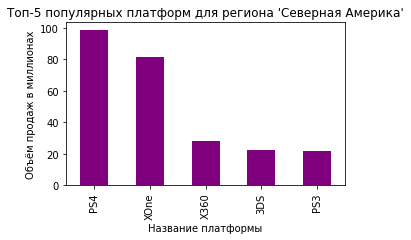

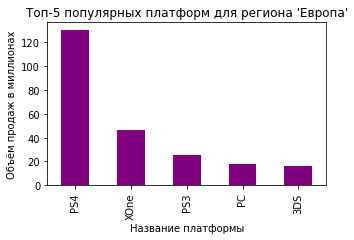

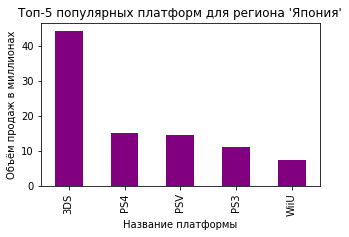

In [76]:
for region_sales_column in region_sales_columns:
    
    region_name = det_region_name(region_sales_column)

    df_actual.groupby('platform')[region_sales_column].\
          sum().sort_values(ascending=False)[:5].plot(
        figsize=(5, 3), kind='bar', xlabel='Название платформы', ylabel='Объём продаж в миллионах',
        title=f"Топ-5 популярных платформ для региона '{region_name}'",
        color='purple');
    
    plt.show()

Наблюдения:
* Списки топ-4 платформ схожи для Северной Америки и Европы. В него входят одни и те же платформы, но в разном порядке: X360, PS3, Wii и DS.
* Платформой-лидером продаваемых игр в Северной Америке является X360, а в Европе - PS3. Важно отметить, что указанные платформы заметно, но не существенно превосходят по продажам остальные платформы в списке топов.
* Список топ-5 платформ для Японии кардинально отличается от двух других регионов.
* Платформой-лидером продаваемых игр в Японии является DS. Важно заметить, что объём продаж для этой платформы приблизительно в 2 раза выше, чем для остальных платформ из списка. Остальные четыре платформы (3DS, PS3, PSP и Wii) примерно схожи в объёмах продаж.

**4.2. Самые популярные жанры для каждого региона**

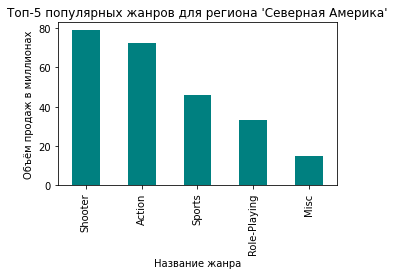

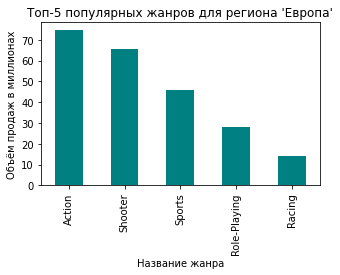

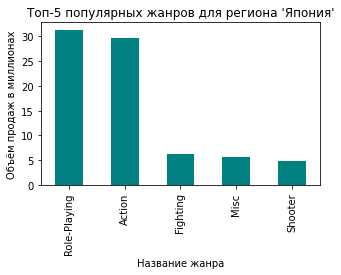

In [77]:
for region_sales_column in region_sales_columns:
    
    region_name = det_region_name(region_sales_column)

    df_actual.groupby('genre')[region_sales_column].\
          sum().sort_values(ascending=False)[:5].plot(
        figsize=(5, 3), kind='bar', xlabel='Название жанра', ylabel='Объём продаж в миллионах',
        title=f"Топ-5 популярных жанров для региона '{region_name}'",
        color='teal');
    
    plt.show()

Наблюдения:
* Для регионов "Северная Америка" и "Европа" распределения игровых жанров по популярности схожи. 
* Бесспорным лидером среди жанров является Action (экшн), затем идут жанры Sports, Shooter и Misc (буквально в таком же порядке для обоих регионов). При этом, пятый жанров в каждом из топов различается: в Америке больше предпочитают ролевые игры, в то время как пятое место по популярности в Европе занимает жанр гонок.
* В Японии распределение жанров - другое. На первом месте с большим отрывом находится жанр ролевых игр. Action, Misc и Sports идут следом, но с заметным отставанием по продажам. Последнее место в топе занимает жанр платформенных игр, который не является сильно популярным в США и Европе.

**4.3. Влияние рейтинга ESRB на продажи в отдельном регионе**

**Категории рейтинга ESRB:**
* «EC» («Early childhood») — «Для детей младшего возраста»: Игра подходит для детей от 3 лет и старше и не содержит материалов, которые родители могли бы счесть неподходящими. 
* «E» («Everyone») — «Для всех»: Содержание вполне подходит для возрастной категории от 6 лет и старше; такие игры могут понравиться и взрослым. Игры с этим рейтингом могут содержать минимальное насилие, в основном «мультяшного» характера. Первой игрой, которая получила данный рейтинг, стала The Simpsons Cartoon Studio(aнг.), выпущенная в 1996 году.
* «E10+» («Everyone 10 and older») — «Для всех старше 10 лет»: Возрастная категория — от 10 лет. Проекты с данным рейтингом могут содержать немного больше мультипликационного или мягкого насилия, или несколько откровенные сцены или минимальное количество крови. Рейтинг был принят ESRB 2 марта 2005 года. Первой игрой, которая получила данный рейтинг, стала Donkey Kong: Jungle Beat.
* «T» («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет и старше. Проекты из данной категории могут содержать насилие, непристойные сцены, грубый юмор, в меру откровенное сексуальное содержимое, кровь или нечастое использование ненормативной лексики.
* «M» («Mature») — «От 17 лет»: Материалы игры не подходят для подростков младше 17 лет. Проекты с данным рейтингом могут содержать достаточно жестокое насилие, большое количество крови с расчленением, непристойные сексуальные сцены или грубую ненормативную лексику, нежелательную для младшей аудитории. Некоторые торговые сети не продают игры с таким рейтингом несовершеннолетним без согласия родителей.
* «AO» («Adults Only 18+») — «Только для взрослых»: Содержание игры только для взрослых. Продукты из данной категории могут содержать длительные сцены жестокого насилия и/или очень откровенное сексуальное содержимое, а также сцены с обнажением. В 2006-м году данный рейтинг получили 22 продукта, большинство из которых предназначены для персональных компьютеров под управлением Windows и Apple Macintosh. Рейтинг «Только для взрослых» является предметом многочисленных дискуссий, так как накладывает серьёзные ограничения на продажи игры.
* «RP» («Rating Pending»“) — «Рейтинг ожидается»: Продукт был отправлен в ESRB и ожидает присвоения рейтинга. Данный логотип используется только на рекламных презентациях и в демо-версиях игр до официального релиза

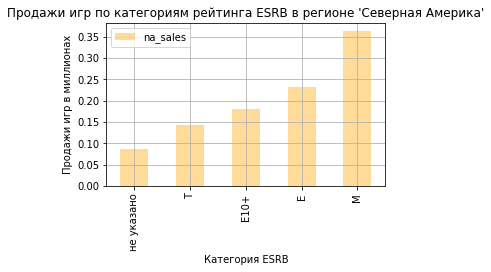

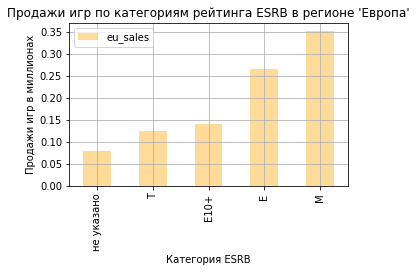

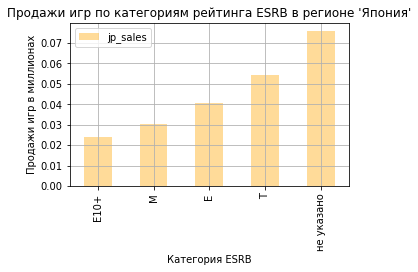

In [78]:
for region_sales_column in region_sales_columns:
    
    region_name = det_region_name(region_sales_column)

    df_actual.pivot_table(index='rating',
                          values=region_sales_column,
                          aggfunc='mean').sort_values(by=region_sales_column).\
    plot(
        kind='bar',
        grid=True,
        figsize=(5, 3),
        xlabel='Категория ESRB',
        ylabel='Продажи игр в миллионах',
        title=f"Продажи игр по категориям рейтинга ESRB в регионе '{region_name}'",
        color='orange',
        alpha=0.4);

    plt.show()

**Наблюдения:**
* Распределения продаж игр по рейтингу ESRB для Северной Америки и Европы очень похожи.
* Наибольшим спросом в Америке и Европе пользуются игры категории AO (только для взрослых, 18+). Это - бесспорный лидер в плане продаж относительно остальных категорий. Затем идут игры группы M (от 17 лет), E (для всех), E10+ (для всех старше 10 лет) и T (подростки). Последние четыре группы расположены в порядке убывания продаж.
* В Америке также распространена категория EC (раннее детство), в то время как в Европе её совсем не наблюдается.
* Распределение продаж игр по рейтингу ESRB для Японии кардинально отличается от предыдущих двух регионов.
* Самыми продаваемыми играми в Японии являются продукты с рейтингом E (для всех) и, чуть менее популярны, игры с рейтингом T (подростки). Заметно меньше, но в то же время распространены игры с рейтингами M (от 17 лет) и E10+ (для всех старше 10 лет).
* Игр с рейтингами AO (только для взрослых, 18+) и EC (раннее детство) в Японии не продают.
* Поскольку рейтинг ESRB распространяется только на игры в США и Канаде, на диаграмме Японии мы видим, что наибольшая группа проданных игр в этом регионе попросту не имеет рейтинга от данной организации. Такое наблюдение не повторяется в Америке и Канаде, где группа игр без рейтинга от ESRB занимает последнее место для обоих регионов.

# 5. Проверка гипотез

**5.1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые**

H0: Средние пользовательские рейтинги для платформы XOne равны аналогичным показателям для платформы PC
H1: Средние пользовательские рейтинги для платформы XOne НЕ равны аналогичным показателям для платформы PC

In [79]:
df_actual = df_actual[df_actual['user_score'] != 'не указано']

df_actual['user_score'] = df_actual['user_score'].astype('float')

In [82]:
print(len(df_actual[df_actual['platform'] == 'XOne'].user_score))
print(len(df_actual[df_actual['platform'] == 'PC'].user_score))

165
122


Видно, что выборки по размеру разные, поэтому важно будет указать параметр equal_var = False при проверке гипотезы.

In [83]:
alpha = .05

results = st.ttest_ind(
    df_actual[df_actual['platform'] == 'XOne'].user_score, 
    df_actual[df_actual['platform'] == 'PC'].user_score,
    equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.11601398086668832
Не получилось отвергнуть нулевую гипотезу


Наши данные не противоречат тому, что средние пользовательские рейтинги для платформы XOne могут быть равны аналогичным показателям для платформы PC. Эту гипотезу мы не отвергаем.

**5.2. Средние пользовательские рейтинги жанров Action и Sports разные**

H0: Средние пользовательские рейтинги для жанра Action равны аналогичным показателям для жанра Sports

H1: Средние пользовательские рейтинги для жанра Action НЕ равны аналогичным показателям для жанра Sports

In [86]:
print(len(df_actual[df_actual['genre'] == 'Action'].user_score))
print(len(df_actual[df_actual['genre'] == 'Sports'].user_score))

297
127


Выборки снова различаются по размеру, поэтому оставляем параметр equal_var = False

In [87]:
alpha = .05

results = st.ttest_ind(
    df_actual[df_actual['genre'] == 'Action'].user_score, 
    df_actual[df_actual['genre'] == 'Sports'].user_score,
    equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 1.1825550382644557e-14
Отвергаем нулевую гипотезу


Наши данные противоречат тому, что средние пользовательские рейтинги для жанра Action раны аналогичным показателям для жанра Sports. Отвергаем эту гипотезу.

**5.3. Как я сформулировал нулевую и альтернативную гипотезы**

Поскольку, согласно теории, *H₀ всегда формулируется так, чтобы использовать знак равенства*, я составил обе нулевые гипотезы, утверждая, что рассматриваемые средние величины равны между собой. По аналогии с этим я составил альтернативные гипотезы, которые отрицают равенство между двух рассматриваемых величин.

**5.4. Какой критерий я применил для проверки гипотез и почему**

Я сравнил результаты t-test'ов для средних двух независимых совокупностей с критических уровнем статистической значимости. Если результаты t-test'а были меньше данного уровня, то предлагалось отклонить нулевую гипотезу в каждом из случаев.

# Общие выводы

* Продажи игр для топ-10 платформ осуществлялись в среднем в течение 9.6 лет, но большая часть продаж приходилась на 5-6 лет из этого периода
* Новые платформы возникали в течение чуть ли не каждого года, в то время как старые платформы исчезали в течение ~3 лет
* По суммарным продажам РАНЬШЕ лидировали следующие платформы: DS, Wii, PS3 и X360
* ТЕПЕРЬ наиболее прибыльными можно считать эти платформы: X360, PS3, PS4, 3DS, XOne (где PS4 и XOne — очевидные лидеры)
* Объём продаж прямо пропорционально зависит от отзывов критиков (чем выше рейтинг от эксперта, тем выше продажи). 
* Продажи PS4 & XOne вообще не зависят от пользовательских оценок, в то время как для платформ 3DS, PS3 и X360 такая зависимость прослеживается, хотя и слабая.
* Бесспорным лидером продаж среди игровых жанров являются шутеры или "стрелялки". Их объём продаж превосходит второе место по продажам - спортивные игры - больше чем в ~2.5 раза. Остальные жанры продаются примерно в одном и том же диапазоне.
* Жанры игр, которые продаются заметно реже остальных - это Adventure, Puzzle и Strategy. Жанр "Приключения" является самым плохо продаваемым относительно остальных.
* Списки топ-5 самых популярных платформ схожи для Северной Америки и Европы. Платформами-лидерами являются PS4 и XOne.
* Список топ-5 платформ для Японии отличается от двух других регионов. На первом месте по продажам сильно выделяется платформа 3DS.
* Как и в случае с жанрами, для регионов "Северная Америка" и "Европа" распределения игровых жанров по популярности схожи. Лидерами среди жанров являются Shooter (стрелялки) и Action (экшн).
* В Японии распределение жанров немного другое. На первом месте находятся жанры ролевых игр и экшн.
* Буквально то же самое релевантно и для рейтинга ESRB. Распределения продаж игр по этому рейтингу для Северной Америки и Европы очень похожи. Наибольшим спросом в Америке и Европе пользуются игры категорий (по убыванию продаж) M, E и T.
* Для большинства проданных игр в Японии такой рейтинг не присвоен. Всё дело в том, что данный рейтинг распространяется только на США и Европу. При этом, где такой рейтинг указан, лидируют игры категории (по убыванию продаж) T, E и М.
* Наши данные не противоречат тому, что средние пользовательские рейтинги для платформы XOne могут быть равны аналогичным показателям для платформы PC. Эту гипотезу мы **не отвергаем**.
* Наши данные противоречат тому, что средние пользовательские рейтинги для жанра Action раны аналогичным показателям для жанра Sports. Эту гипотезу мы **отвергаем**.


# Выбор игр для запуска рекламной кампании

Проанализировав продажи игр для интернет-магазина по всему миру, теперь мы можем сделать решение в пользу тех или иных игровых продуктов для запуска рекламной кампании.

**К рекламе предлагаются наиболее популярные игры со следующими характеристиками:**
* Платформы: PS4 & XOne
* Жанры: Shooter & Action
* Рейтинг ESRB: M & E
* Рейтинг критиков: чем выше, тем лучше - это в какой-то степени будет прямопропорционально влиять на объём продаж
* Рейтинг пользователей: любой
* Регионы: Северная Америка и Европа

In [88]:
df_actual[
    (df['platform'].isin(['PS4', 'XOne'])) &
    (df['genre'].isin(['Shooter', 'Action'])) &
    (df['rating'].isin(['M', 'E']))
     ]

,game,platform,release_year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8.3,M,12.62
92,Call of Duty: Advanced Warfare,PS4,2014,Shooter,2.81,3.48,0.14,1.23,83,5.7,M,7.66
165,Grand Theft Auto V,XOne,2014,Action,2.81,2.19,0.00,0.47,97,7.9,M,5.47
179,Call of Duty: Advanced Warfare,XOne,2014,Shooter,3.22,1.55,0.01,0.48,81,5.4,M,5.26
245,Call of Duty: Infinite Warfare,PS4,2016,Shooter,1.61,2.00,0.15,0.71,77,3.4,M,4.47
...,...,...,...,...,...,...,...,...,...,...,...,...
16188,Darksiders: Warmastered Edition,XOne,2016,Action,0.01,0.00,0.00,0.00,80,7.9,M,0.01
16314,Prototype: Biohazard Bundle,XOne,2016,Action,0.01,0.00,0.00,0.00,56,3.1,M,0.01
16530,Carmageddon: Max Damage,PS4,2016,Action,0.01,0.00,0.00,0.00,51,5.5,M,0.01
16533,Rugby League Live 3,XOne,2015,Action,0.00,0.01,0.00,0.00,не указано,7.1,E,0.01


In [89]:
df_actual[
    (df['platform'].isin(['PS4', 'XOne'])) &
    (df['genre'].isin(['Shooter', 'Action'])) &
    (df['rating'].isin(['M', 'E']))
     ].groupby('game')['total_sales'].sum().sort_values(ascending=False)[:5]

game
Grand Theft Auto V                18.09
Call of Duty: Advanced Warfare    12.92
Assassin's Creed: Unity            7.46
Call of Duty: Infinite Warfare     6.89
Battlefield 1                      6.32
Name: total_sales, dtype: float64

**К примеру, это могут быть игры GTA V и COD: AW**